# Detect Inappropriate Content In Your Images

Use Yahoo Open NSFW to detect the possibility that your image is
not suitable for work (pornographic content). Detection ranges from 0 to 100%.

Possible Use Cases:
- Automatically flag inappropriate content uploaded in your online community.
- Block inappropriate images from being loaded for a child-safe environment.
- Continue fine tuning this prediction model on your own dataset to detect a broader set of NSFW content.

## Check Out the IPython Tutorial Below To Get This Model Running!

# Prediction Examples:

NSFW Probability: 0% | NSFW Probability: 15.2% | NSFW Probability: 0.09%
--- | --- | ---
![city skyline with bridge](https://cdn.pixabay.com/photo/2016/10/17/07/53/busan-night-scene-1747130__180.jpg) | ![boy with deer](https://cdn.pixabay.com/photo/2016/11/08/05/31/boy-1807545__180.jpg) | ![couple sitting together](https://cdn.pixabay.com/photo/2017/06/20/22/14/men-2425121__180.jpg)

# How Good Is This Model?

As far as we can tell, **this is the only ML solution** to detecting
not suitable for work (NSFW) content. However, since NSFW content is highly subjective,
we recommend testing the algorithm on your own images, which you can easily do through
running the notebook tutorial below. Different contexts will require different
cutoffs for what probability constitutes NSFW content.

Yahoo has shown that this model accidentally classifies
7% of images as potentially NSFW for an undisclosed cutoff they used in testing.

## Misc

Code licensed under the BSD 2 clause license. See Source Code for more details.

Model trained under ImageNet 1000 class dataset and then fine tuned on
a proprietary NSFW dataset not released by Yahoo.


## Installing Caffe (Ubuntu)

We'll install the pre-built binary for Ubuntu, skip this cell if you already have it set up. Installation instructions for caffe in general can be found here: http://caffe.berkeleyvision.org/installation.html

In [0]:
!apt -y install caffe-cpu

## Downloading Our Model from ModelDepot

Here we'll download the model from ModelDepot (through `wget`) and `unzip` it so we can load it into caffe later.

In [0]:
!wget https://modeldepot.io/assets/uploads/models/models/5005730b-eff1-4700-a553-c13f9bc97a53_nsfw_model.zip
!unzip ./5005730b-eff1-4700-a553-c13f9bc97a53_nsfw_model.zip

## Downloading Test Images

We're just going to quickly grab some images to run through our NSFW classifier. We'll visualize what these images look like below.

In [0]:
!wget https://cdn.pixabay.com/photo/2016/10/17/07/53/busan-night-scene-1747130_960_720.jpg
!wget https://cdn.pixabay.com/photo/2018/01/13/19/39/fashion-3080644_960_720.jpg

## View our Test Images

Let's take a quick look at a couple of images we're going to use to test out the `open_nsfw` model.

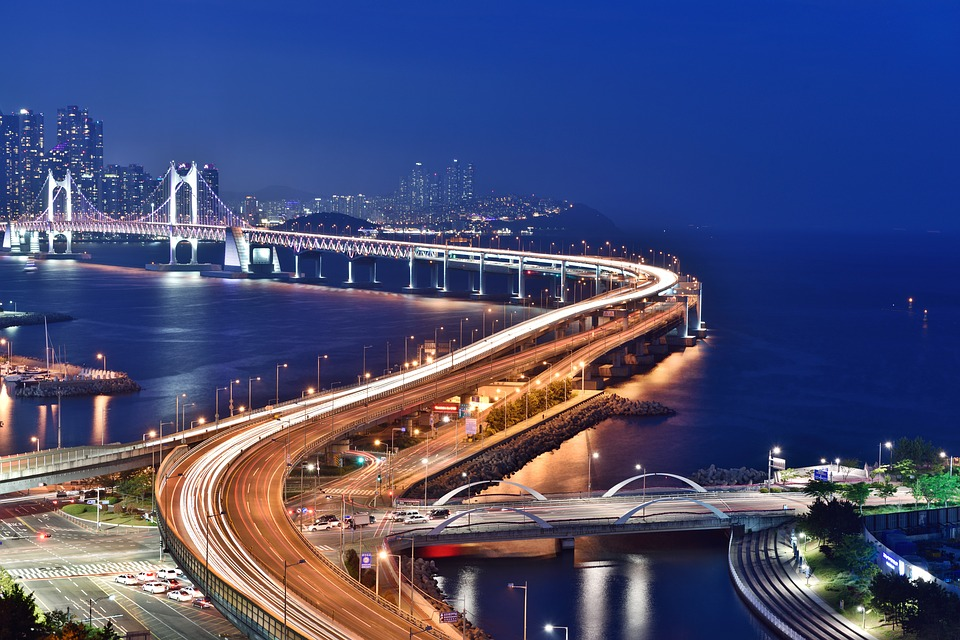

In [0]:
from IPython.display import Image as IImage # Don't collide with PIL.Image
IImage(filename='/content/busan-night-scene-1747130_960_720.jpg', width=420)

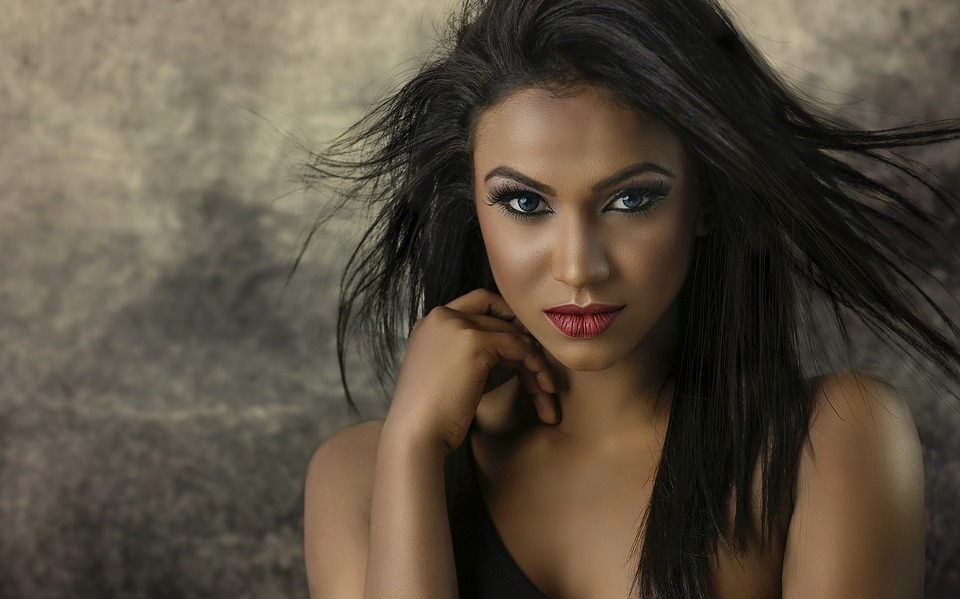

In [0]:
IImage(filename='/content/fashion-3080644_960_720.jpg', width=420)

## Let's Make a Prediction!

The following code is all adopted from the original [`classify_nsfw.py`](https://github.com/yahoo/open_nsfw/blob/master/classify_nsfw.py). It has been modified to work in Python3.

In [0]:
# Grab all our dependencies

import numpy as np
import os
import sys
import argparse
import glob
import time
from PIL import Image
from io import BytesIO
import caffe

We'll simply paste the pre-processing code from the repository. It's important that we keep this intact as varying the pre-processing steps will lead to a degraded performance because the data that was used to train the model was pre-processed in this way.

In [0]:
def resize_image(data, sz=(256, 256)):
    """
    Resize image. Please use this resize logic for best results instead of the 
    caffe, since it was used to generate training dataset 
    :param str data:
        The image data
    :param sz tuple:
        The resized image dimensions
    :returns bytearray:
        A byte array with the resized image
    """
    img_data = data
    # img_data = str(data)
    # img_data = str(open('/content/grief-and-loss.jpg', 'rb').read())
    # im = Image.open(StringIO(img_data))
    im = Image.open(BytesIO(img_data))
    if im.mode != "RGB":
        im = im.convert('RGB')
    imr = im.resize(sz, resample=Image.BILINEAR)
    fh_im = BytesIO()
    imr.save(fh_im, format='JPEG')
    fh_im.seek(0)
    return bytearray(fh_im.read())

def caffe_preprocess_and_compute(pimg, caffe_transformer=None, caffe_net=None,
    output_layers=None):
    """
    Run a Caffe network on an input image after preprocessing it to prepare
    it for Caffe.
    :param PIL.Image pimg:
        PIL image to be input into Caffe.
    :param caffe.Net caffe_net:
        A Caffe network with which to process pimg afrer preprocessing.
    :param list output_layers:
        A list of the names of the layers from caffe_net whose outputs are to
        to be returned.  If this is None, the default outputs for the network
        are returned.
    :return:
        Returns the requested outputs from the Caffe net.
    """
    if caffe_net is not None:

        # Grab the default output names if none were requested specifically.
        if output_layers is None:
            output_layers = caffe_net.outputs

        img_data_rs = resize_image(pimg, sz=(256, 256))
        image = caffe.io.load_image(BytesIO(img_data_rs))

        H, W, _ = image.shape
        _, _, h, w = caffe_net.blobs['data'].data.shape
        h_off = max((H - h) // 2, 0)
        w_off = max((W - w) // 2, 0)
        crop = image[h_off:h_off + h, w_off:w_off + w, :]
        transformed_image = caffe_transformer.preprocess('data', crop)
        transformed_image.shape = (1,) + transformed_image.shape

        input_name = caffe_net.inputs[0]
        all_outputs = caffe_net.forward_all(blobs=output_layers,
                    **{input_name: transformed_image})

        outputs = all_outputs[output_layers[0]][0].astype(float)
        return outputs
    else:
        return []

## Set Up our Model

We'll pull in the model architecture and trained weights pulled from ModelDepot and load it into caffe.

**IMPORTANT!!: Remember to change the path variables to the correct path**

In [0]:
# We're pulling out the model set up code into this cell so that we can
# re-use it across multiple inference runs

# TODO: Change this path to the path that you unzipped the model into!
deploy_prototxt_path = '/content/nsfw_model/deploy.prototxt'
caffemodel_path = '/content/nsfw_model/resnet_50_1by2_nsfw.caffemodel'

# Pre-load caffe model.
nsfw_net = caffe.Net(deploy_prototxt_path, caffemodel_path, caffe.TEST)

# Load transformer
# Note that the parameters are hard-coded for best results
caffe_transformer = caffe.io.Transformer({'data': nsfw_net.blobs['data'].data.shape})
caffe_transformer.set_transpose('data', (2, 0, 1))  # move image channels to outermost
caffe_transformer.set_mean('data', np.array([104, 117, 123]))  # subtract the dataset-mean value in each channel
caffe_transformer.set_raw_scale('data', 255)  # rescale from [0, 1] to [0, 255]
caffe_transformer.set_channel_swap('data', (2, 1, 0))  # swap channels from RGB to BGR

## Predict Helper Function

A generic function that can take in an image path and print out a formated NSFW probabilty string.

In [0]:
def predict(image_path):
    image_data = open(image_path, 'rb').read()

    # Classify.
    scores = caffe_preprocess_and_compute(
        image_data, 
        caffe_transformer=caffe_transformer, 
        caffe_net=nsfw_net, 
        output_layers=['prob']
    )
    
    # Scores is the array containing SFW / NSFW image probabilities
    # scores[1] indicates the NSFW probability
    nsfw_score = scores[1]
    return "NSFW score:  " + '{0:3f}'.format(nsfw_score)

Let's test out our predict helper function.

In [0]:
print(predict('/content/busan-night-scene-1747130_960_720.jpg'))
print(predict('/content/fashion-3080644_960_720.jpg'))

NSFW score:  0.000038
NSFW score:  0.517547


## Results!

Here we're showing the output of the model's prediction on top of the image using matplotlib.

This isn't super necessary but is nice to visualize it in this way. Otherwise, the above
predict method would be good enough to give you the prediction score.

Text(0.5,1,'NSFW score:  0.517547')

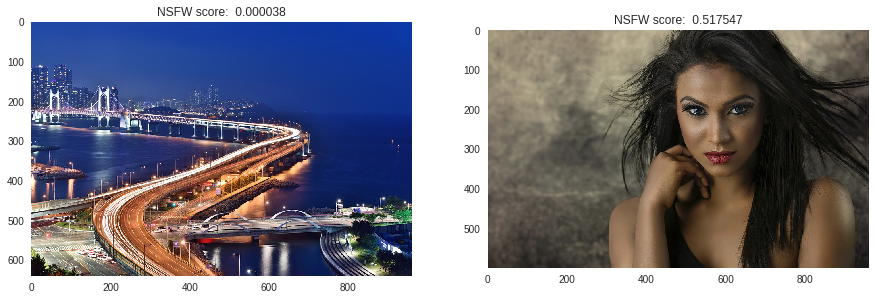

In [0]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(ncols=2, figsize=(15, 5))
axarr[0].imshow(Image.open('/content/busan-night-scene-1747130_960_720.jpg'))
axarr[0].grid(False)
# Actually do prediction on our bridge image
axarr[0].set_title(predict('/content/busan-night-scene-1747130_960_720.jpg'))
axarr[1].imshow(Image.open('/content/fashion-3080644_960_720.jpg'))
axarr[1].grid(False)
# Actually do prediction on our woman image
axarr[1].set_title(predict('/content/fashion-3080644_960_720.jpg'))